# TASK1

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import numpy as np
from scipy import stats
import re
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [3]:
# Load the data, and print the first few rows to see what it looks like
data = pd.read_json('./yt_metadata_filtered_"trump ".jsonl', lines=True)
print(data.head().to_string())

  categories                channel_id                  crawl_date description  dislike_count   display_id  duration  like_count                                                                                                                                      tags                                    title          upload_date  view_count keywords
0     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:33.001044                        6.0  iWbFNJaaHrw       270        47.0                                                          video,games,retrogamer3,ed,findlay,Trump,America's Retribution,Video Games,Steam    America's Retribution Term 2 Launched  2019-05-08 00:00:00       445.0   trump 
1     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:33.563584                        8.0  MRaGK43Ux-k       109        52.0                                                               video,games,retrogamer3,ed,findlay,America's Retribution Term 2,Steam,Trump      America's Retribution Term 2

In [4]:
keywords = ['QAnon', 'Deep State', 'deepstate', "Election Fraud", "Missing Emails", "Biden Family Scandal", "Climate Change Hoax"]  # List of keywords corresponding to conspiracy theories

# Create a mask that selects rows where the title, description, or tags contain any of the keywords
mask_title = data['title'].str.contains('|'.join(keywords), case=False, na=False)
mask_description = data['description'].str.contains('|'.join(keywords), case=False, na=False)
mask_tags = data['tags'].str.contains('|'.join(keywords), case=False, na=False)

# Apply the mask to the data
filtered_data = data[mask_title | mask_description | mask_tags]

categories
News & Politics          320
People & Blogs            77
Entertainment             59
Education                 51
Comedy                    14
Nonprofits & Activism     13
Film & Animation          11
Science & Technology       7
Gaming                     5
Music                      3
Autos & Vehicles           2
Howto & Style              1
Travel & Events            1
Name: count, dtype: int64


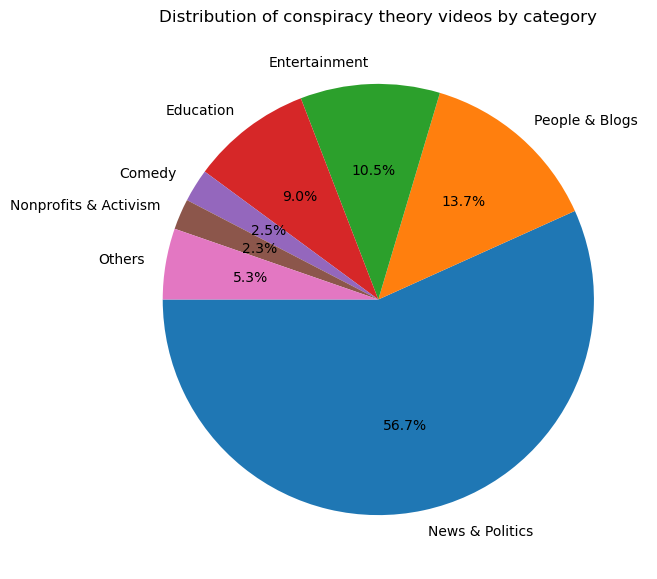

In [ ]:
# Count the number of videos in each category
category_counts = filtered_data.drop_duplicates(subset='channel_id')['categories'].value_counts()
print(category_counts)

# Plot the distribution of conspiracy theory videos by category
threshold = 0.02  # 2% threshold
other_count = category_counts[category_counts / category_counts.sum() < threshold].sum()
main_categories = category_counts[category_counts / category_counts.sum() >= threshold]
main_categories['Others'] = other_count

plt.figure(figsize=(10, 7))
main_categories.plot(kind='pie', autopct='%1.1f%%', startangle=180)
plt.title('Distribution of conspiracy theory videos by category')
plt.ylabel('')
plt.show()

#### From the pie chart above, we can see that conspiracy theory videos are primarily concentrated in the following categories: News & Politics, People & Blogs, Entertainment, and Education. These four categories account for the vast majority of conspiracy theory videos, with 320, 77, 59, and 51 videos respectively. Other categories such as Comedy, Nonprofits & Activism, Film & Animation, and Science & Technology have relatively fewer videos.

In [41]:
# Load the Time Series Data
df_sb_f = pd.read_csv("./df_timeseries_en.tsv.gz", compression="infer", sep="\t")
df_sb_f["datetime"] = pd.to_datetime(df_sb_f["datetime"])

In [7]:
# Filter the time series data to include only the channels that have conspiracy theory videos
channels = filtered_data["channel_id"].unique()
filtered_ts = df_sb_f[df_sb_f["channel"].isin(channels)]

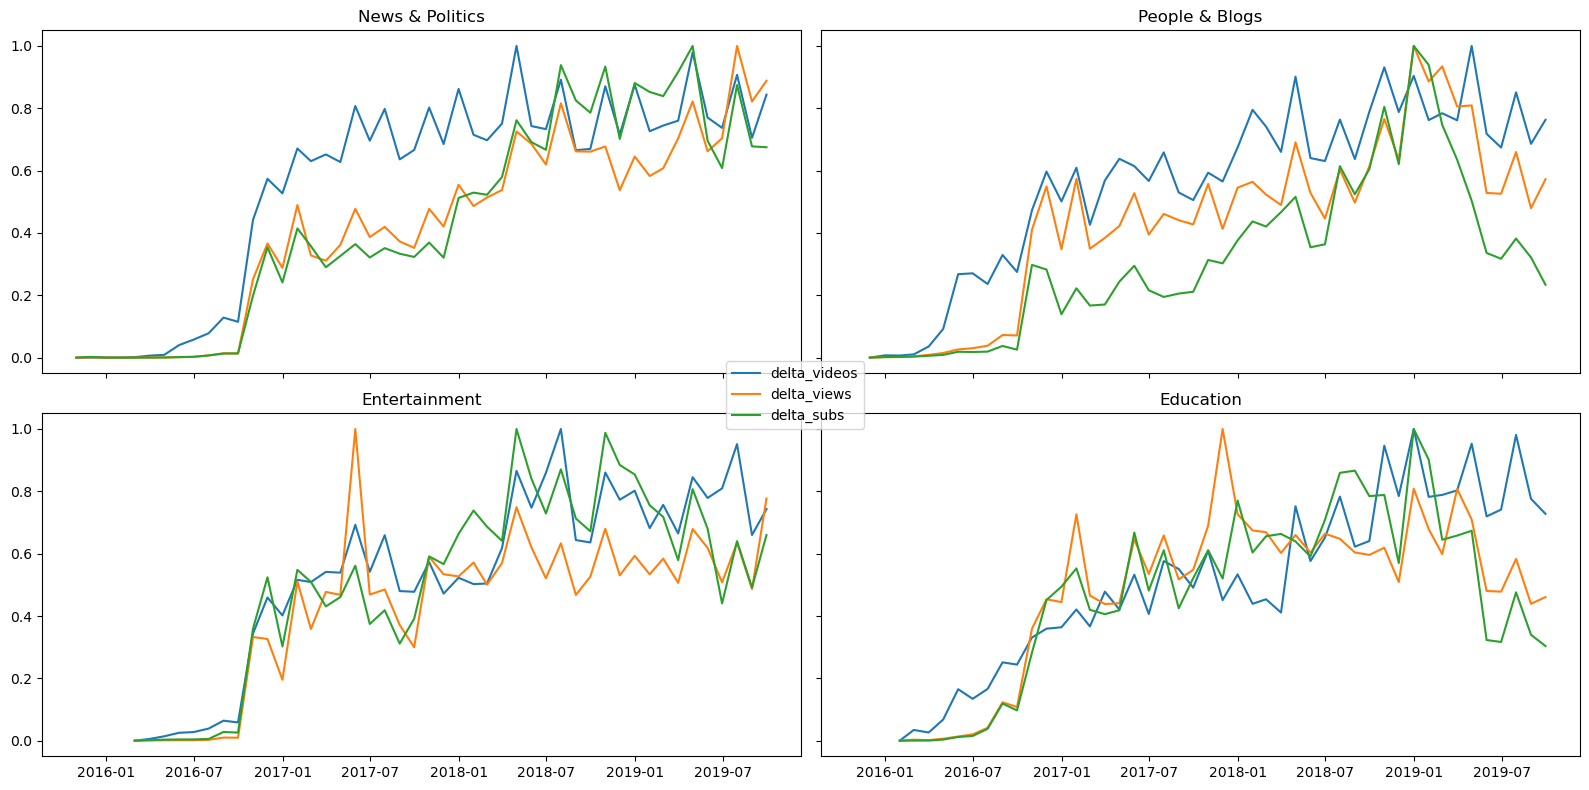

In [ ]:
def aggregate_by_month(data, category):
    # Filter data by category and set datetime as index
    ts_category = data[data['category'] == category].set_index('datetime')
    # Resample data by month-end and sum up the values
    return ts_category[['delta_videos', 'delta_views', 'delta_subs']].resample('ME').sum()

def normalize_data(data):
    # Normalize data to a 0-1 range
    return (data - data.min()) / (data.max() - data.min())

def smooth_data(data, window_size=3):
    # Apply a simple moving average for smoothing
    return data.rolling(window=window_size, min_periods=1).mean()

# Create a 2x2 subplot for different categories
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(16, 8))

# Define categories to plot
categories = ['News & Politics', 'People & Blogs', 'Entertainment', 'Education']

# Plot normalized and smoothed data for each category
for i, category in enumerate(categories):
    row, col = divmod(i, 2)
    monthly_data = normalize_data(aggregate_by_month(filtered_ts, category))
    smoothed_data = smooth_data(monthly_data)
    ax[row, col].plot(smoothed_data['delta_videos'], label='delta_videos')
    ax[row, col].plot(smoothed_data['delta_views'], label='delta_views')
    ax[row, col].plot(smoothed_data['delta_subs'], label='delta_subs')
    ax[row, col].set_title(category)

# Add legend and adjust layout
fig.legend(['delta_videos', 'delta_views', 'delta_subs'], loc='center')
fig.tight_layout()


#### This chart dives into the wild world of conspiracy content on YouTube, comparing *News & Politics*, *People & Blogs*, *Entertainment*, and *Education*. *News & Politics* steals the show with big spikes in views, uploads, and subscribers in 2018-2019, showing just how hooked audiences were during major events. *People & Blogs* keeps uploading steadily, though views and subs don’t stick around as much, hinting at viewer curiosity without loyalty. *Entertainment* grabs attention early, but interest cools off, while *Education* draws in an initial crowd that gradually fades, suggesting a steady but niche appeal. Let’s dive deeper to see what fuels these rollercoaster trends!

# TASK2

In [10]:

df_channels = pd.read_csv('df_channels_en.tsv', sep='\t')

In [11]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

df_metadata = load_jsonl('yt_metadata_filtered_"trump ".jsonl')
df_metadata.rename(columns={'channel_id': 'channel'}, inplace=True)

In [12]:
df_channels.dropna(subset=['channel'], inplace=True)
df_metadata.fillna({'description': '', 'tags': '', 'keywords': ''}, inplace=True)


# Remove duplicates
df_channels.drop_duplicates(subset=['channel'], inplace=True)
df_metadata.drop_duplicates(subset=['display_id'], inplace=True)


# Standardize channel ID format
df_channels['channel'] = df_channels['channel'].str.upper()
df_metadata['channel'] = df_metadata['channel'].str.upper()


# Merge channel and video data
df_combined = pd.merge(df_metadata, df_channels, left_on='channel', right_on='channel', how='left')

# Check merge results
print(len(df_metadata))
print(len(df_combined))
print(df_combined.head().to_string())


447616
447616
  categories                   channel                  crawl_date description  dislike_count   display_id  duration  like_count                                                                                                                                      tags                                    title          upload_date  view_count keywords category_cc   join_date     name_cc  subscribers_cc  videos_cc  subscriber_rank_sb  weights
0     Gaming  UCZWM1-4XF7AHXVUTKHCM1UW  2019-11-17 06:28:33.001044                        6.0  iWbFNJaaHrw       270        47.0                                                          video,games,retrogamer3,ed,findlay,Trump,America's Retribution,Video Games,Steam    America's Retribution Term 2 Launched  2019-05-08 00:00:00       445.0   trump       Gaming  2008-07-18  Ed Findlay           11884        311            857247.0  14.1935
1     Gaming  UCZWM1-4XF7AHXVUTKHCM1UW  2019-11-17 06:28:33.563584                        8.0  MRaGK43

In [14]:
print(df_combined.columns)

Index(['categories', 'channel', 'crawl_date', 'description', 'dislike_count',
       'display_id', 'duration', 'like_count', 'tags', 'title', 'upload_date',
       'view_count', 'keywords', 'category_cc', 'join_date', 'name_cc',
       'subscribers_cc', 'videos_cc', 'subscriber_rank_sb', 'weights'],
      dtype='object')


In [15]:

conspiracy_keywords = {
    "Deep State": ["deepstate", "deep state", "government faction", "shadow government", "hidden government"],
    "Election Fraud": ["election fraud", "vote fraud", "mail-in ballots", "voter suppression", "rigged election"],
    "QAnon": ["qanon", "cabal", "child trafficking", "satanic rituals", "deep-rooted cabal", "Q movement"],
    "Missing Emails": ["missing emails", "deleted emails", "clinton emails", "email scandal", "email leak"],
    "Biden Family Scandal": ["biden family scandal", "hunter biden", "biden corruption", "biden business dealings", "biden influence"],
    "Climate Change Hoax": ["climate change hoax", "global elites", "climate profit", "false climate", "climate deception"]
}

In [17]:
# Check if a text contains any of the conspiracy theories
def detect_conspiracy_types(row, keywords_dict):
    # Combine relevant text fields
    text = ' '.join([str(row['title']), str(row['description']), str(row['tags'])]).lower()
    detected = {}
    for theory, keywords in keywords_dict.items():
        # Use regular expressions for matching
        pattern = re.compile('|'.join([re.escape(word) for word in keywords]), re.IGNORECASE)
        if pattern.search(text):
            detected[theory] = 1
            continue
        else:
            detected[theory] = 0
    return pd.Series(detected)


In [18]:
# Initialize list to store records with conspiracy keywords
df_combined = df_combined.fillna({'title': '', 'description': '', 'tags': '', 'keywords': ''})

conspiracy_detection = df_combined.apply(lambda row: detect_conspiracy_types(row, conspiracy_keywords), axis=1)
df_combined_with_conspiracy = pd.concat([df_combined, conspiracy_detection], axis=1)

# Add an overall conspiracy flag
df_combined_with_conspiracy['is_conspiracy'] = df_combined_with_conspiracy[list(conspiracy_keywords.keys())].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# View results
print("\nconspiracy_detection:")
print(df_combined_with_conspiracy[['title', 'is_conspiracy'] + list(conspiracy_keywords.keys())].head().to_string())

print("\nconspiracy_detection_overall:")
print(df_combined_with_conspiracy['is_conspiracy'].value_counts())



conspiracy_detection:
                                     title  is_conspiracy  Deep State  Election Fraud  QAnon  Missing Emails  Biden Family Scandal  Climate Change Hoax
0    America's Retribution Term 2 Launched              0           0               0      0               0                     0                    0
1      America's Retribution Term 2 promo!              0           0               0      0               0                     0                    0
2  The last mini boss is done. The fuhrer.              0           0               0      0               0                     0                    0
3          Elizabeth Warren Boss Finished!              0           0               0      0               0                     0                    0
4           America's Retribution -Stream-              0           0               0      0               0                     0                    0

conspiracy_detection_overall:
is_conspiracy
0    438532
1      9

In [ ]:
# get non-conspiracy records
# non_conspiracy_df = pd.DataFrame(non_conspiracy_records)
pd.set_option('display.float_format', '{:,.2f}'.format)
# # Display the first few rows of the DataFrame

non_conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 0]
print('without conspiracy')
print(non_conspiracy_df['view_count'].describe())
print('with conspiracy')
print(df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]['view_count'].describe())


without conspiracy
count       438,502.00
mean         63,287.61
std         794,433.20
min               0.00
25%             712.00
50%           3,983.00
75%          21,288.00
max     254,265,977.00
Name: view_count, dtype: float64
with conspiracy
count        9,082.00
mean        46,751.37
std        290,382.99
min              2.00
25%          2,433.25
50%          8,567.50
75%         30,199.50
max     21,382,840.00
Name: view_count, dtype: float64


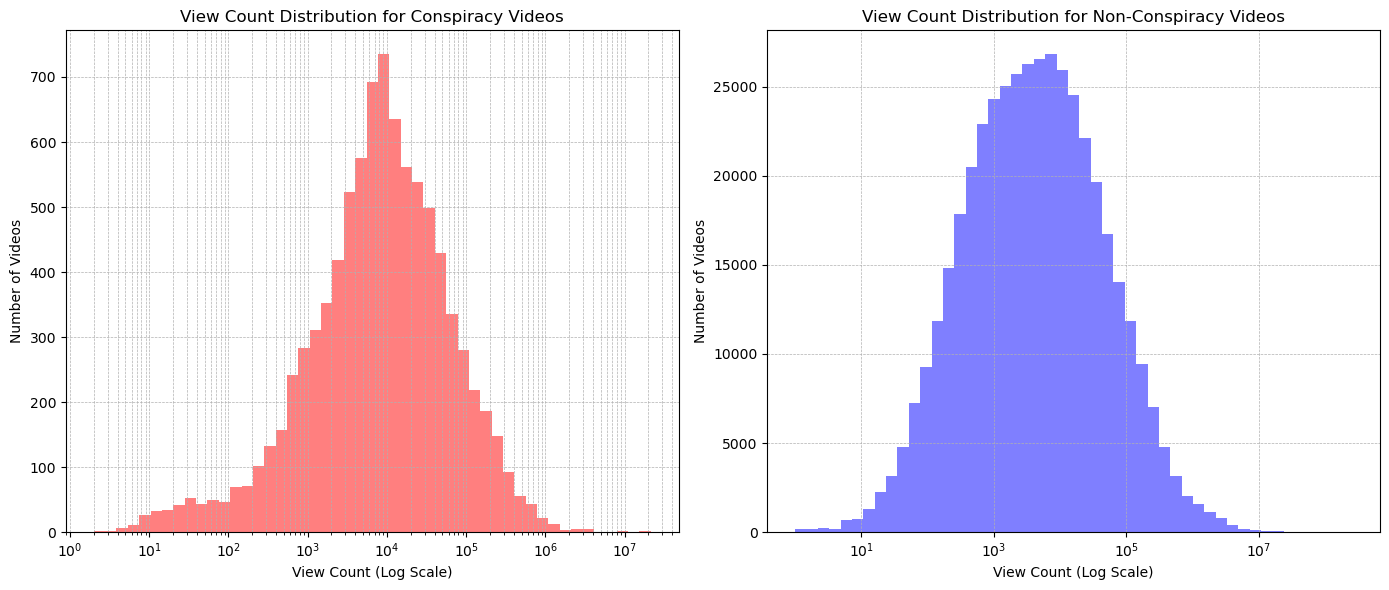

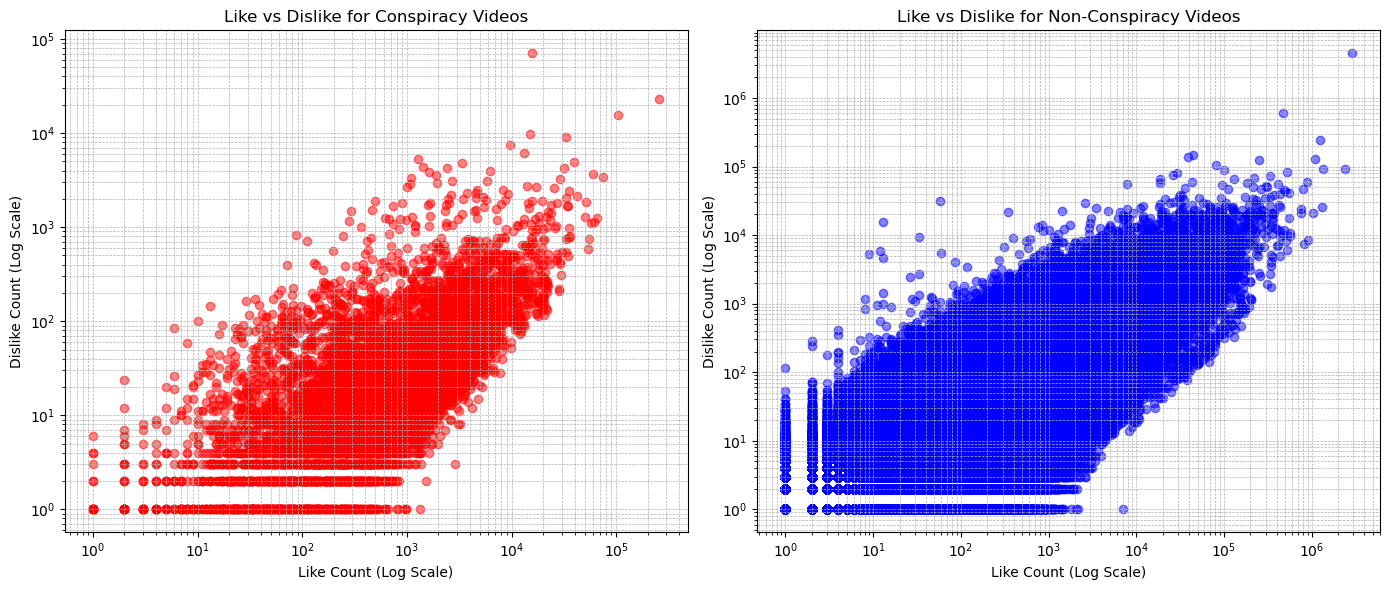

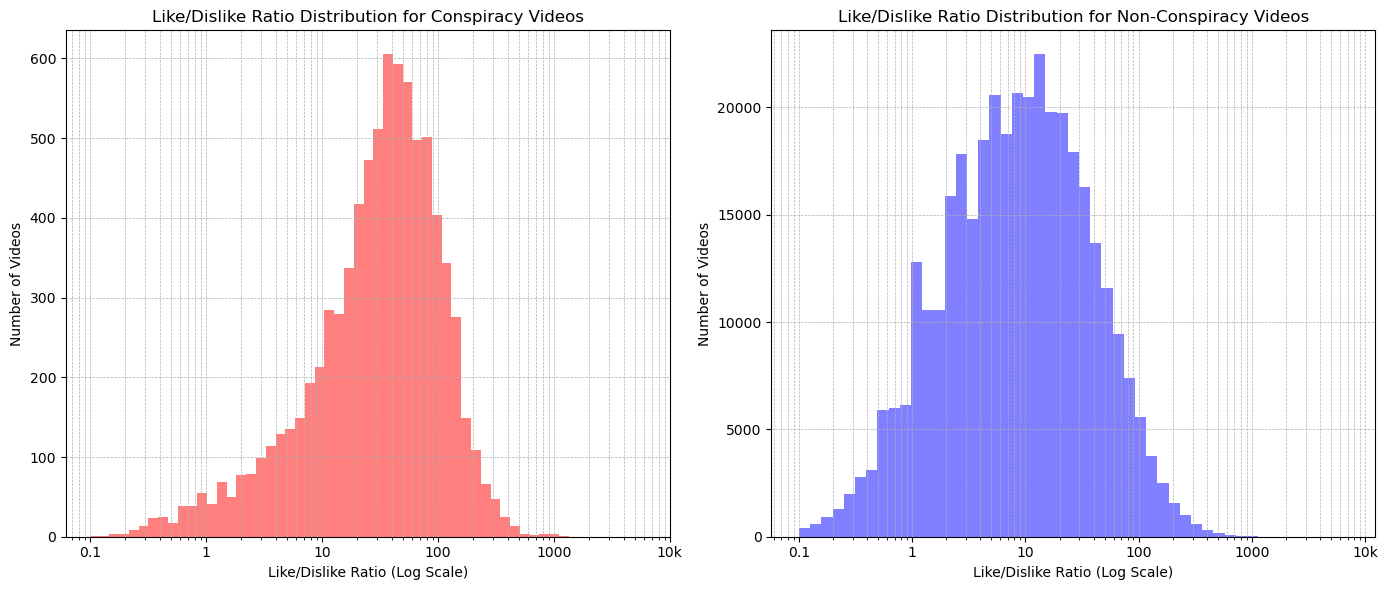

In [ ]:

# Filter conspiracy and non-conspiracy DataFrames
conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 1]
non_conspiracy_df = df_combined_with_conspiracy[df_combined_with_conspiracy['is_conspiracy'] == 0]

# Plot 1: View Count Distribution (Log Scale)
plt.figure(figsize=(14, 6))

# Conspiracy
plt.subplot(1, 2, 1)
view_counts_conspiracy = conspiracy_df['view_count']
view_counts_conspiracy = view_counts_conspiracy[view_counts_conspiracy > 0]
plt.hist(view_counts_conspiracy, bins=np.logspace(np.log10(view_counts_conspiracy.min()), np.log10(view_counts_conspiracy.max()), 50), alpha=0.5, color='r')
plt.xscale('log')
plt.xlabel('View Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('View Count Distribution for Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Non-Conspiracy
plt.subplot(1, 2, 2)
view_counts_non_conspiracy = non_conspiracy_df['view_count']
view_counts_non_conspiracy = view_counts_non_conspiracy[view_counts_non_conspiracy > 0]
plt.hist(view_counts_non_conspiracy, bins=np.logspace(np.log10(view_counts_non_conspiracy.min()), np.log10(view_counts_non_conspiracy.max()), 50), alpha=0.5, color='b')
plt.xscale('log')
plt.xlabel('View Count (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('View Count Distribution for Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Plot 2: Like vs Dislike Scatter Plot (Log Scale)
plt.figure(figsize=(14, 6))

# Conspiracy
plt.subplot(1, 2, 1)
plt.scatter(conspiracy_df['like_count'], conspiracy_df['dislike_count'], color='r', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Like Count (Log Scale)')
plt.ylabel('Dislike Count (Log Scale)')
plt.title('Like vs Dislike for Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Non-Conspiracy
plt.subplot(1, 2, 2)
plt.scatter(non_conspiracy_df['like_count'], non_conspiracy_df['dislike_count'], color='b', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Like Count (Log Scale)')
plt.ylabel('Dislike Count (Log Scale)')
plt.title('Like vs Dislike for Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Plot 3: Like/Dislike Ratio Distribution (Log Scale)
plt.figure(figsize=(14, 6))

# Conspiracy
plt.subplot(1, 2, 1)
like_count_conspiracy = conspiracy_df['like_count']
dislike_count_conspiracy = conspiracy_df['dislike_count'].replace(0, np.nan)
conspiracy_df['like_dislike_ratio'] = like_count_conspiracy / dislike_count_conspiracy
ratio_data_conspiracy = conspiracy_df['like_dislike_ratio'].dropna()
plt.hist(ratio_data_conspiracy, bins=np.logspace(-1, np.log10(ratio_data_conspiracy.max()), 50), alpha=0.5, color='r')
plt.xscale('log')
plt.xticks([0.1, 1, 10, 100, 1000, 10000], labels=[0.1, 1, 10, 100, 1000, '10k'])
plt.xlabel('Like/Dislike Ratio (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('Like/Dislike Ratio Distribution for Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Non-Conspiracy
plt.subplot(1, 2, 2)
like_count_non_conspiracy = non_conspiracy_df['like_count']
dislike_count_non_conspiracy = non_conspiracy_df['dislike_count'].replace(0, np.nan)
non_conspiracy_df['like_dislike_ratio'] = like_count_non_conspiracy / dislike_count_non_conspiracy
ratio_data_non_conspiracy = non_conspiracy_df['like_dislike_ratio'].dropna()
plt.hist(ratio_data_non_conspiracy, bins=np.logspace(-1, np.log10(ratio_data_non_conspiracy.max()), 50), alpha=0.5, color='b')
plt.xscale('log')
plt.xticks([0.1, 1, 10, 100, 1000, 10000], labels=[0.1, 1, 10, 100, 1000, '10k'])
plt.xlabel('Like/Dislike Ratio (Log Scale)')
plt.ylabel('Number of Videos')
plt.title('Like/Dislike Ratio Distribution for Non-Conspiracy Videos')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [ ]:
# Make sure view_count is not NaN
conspiracy_view_counts = conspiracy_df['view_count'].dropna()
non_conspiracy_view_counts = non_conspiracy_df['view_count'].dropna()

# Perform two-sided t-test
t_stat, p_value_two_sided = stats.ttest_ind(conspiracy_view_counts, non_conspiracy_view_counts, equal_var=False)

# Convert to one-sided p-value
# We're interested in whether conspiracy videos have *more* views, so we halve the two-sided p-value if t-statistic is positive
if t_stat > 0:
    p_value_one_sided = p_value_two_sided / 2
else:
    p_value_one_sided = 1 - (p_value_two_sided / 2)

print(f"T-statistic: {t_stat}, one-sided p-value: {p_value_one_sided}")

# Interpret the results for one-sided test
if p_value_one_sided < 0.05:
    print("Results are significant: Conspiracy videos have significantly more view counts than non-conspiracy videos.")
elif 1 - p_value_one_sided < 0.05:
    print("Results are significant: Conspiracy videos have significantly less view counts than non-conspiracy videos.")
else:
    print("Results are not significant: No significant evidence that conspiracy videos have more view counts than non-conspiracy videos.")


T-statistic: -5.049657598512491, one-sided p-value: 0.9999997754795166
Results are significant: Conspiracy videos have significantly less view counts than non-conspiracy videos.


In [ ]:

# Make copies to avoid SettingWithCopyWarning
conspiracy_df = conspiracy_df.copy()
non_conspiracy_df = non_conspiracy_df.copy()

# Drop missing values (NaN) in like_count and dislike_count
conspiracy_like_count = conspiracy_df['like_count'].dropna()
non_conspiracy_like_count = non_conspiracy_df['like_count'].dropna()

conspiracy_dislike_count = conspiracy_df['dislike_count'].dropna()
non_conspiracy_dislike_count = non_conspiracy_df['dislike_count'].dropna()

# Perform t-tests after filtering out zero or constant values
if len(conspiracy_like_count.unique()) > 1 and len(non_conspiracy_like_count.unique()) > 1:
    # T-test - Like Count
    t_stat_like, p_value_like = stats.ttest_ind(conspiracy_like_count, non_conspiracy_like_count, equal_var=False)
    print(f"Like Count - T-statistic: {t_stat_like}, p-value: {p_value_like}")

    if p_value_like < 0.05:
        if t_stat_like > 0:
            print("Conspiracy videos have significantly more likes than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have significantly more likes than conspiracy videos.")
    else:
        print("No significant difference in like count between conspiracy and non-conspiracy videos.")
else:
    print("Like Count: One or both groups have zero variance, cannot perform t-test.")

if len(conspiracy_dislike_count.unique()) > 1 and len(non_conspiracy_dislike_count.unique()) > 1:
    # T-test - Dislike Count
    t_stat_dislike, p_value_dislike = stats.ttest_ind(conspiracy_dislike_count, non_conspiracy_dislike_count, equal_var=False)
    print(f"\nDislike Count - T-statistic: {t_stat_dislike}, p-value: {p_value_dislike}")

    if p_value_dislike < 0.05:
        if t_stat_dislike > 0:
            print("Conspiracy videos have significantly more dislikes than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have significantly more dislikes than conspiracy videos.")
    else:
        print("No significant difference in dislike count between conspiracy and non-conspiracy videos.")
else:
    print("Dislike Count: One or both groups have zero variance, cannot perform t-test.")

# Drop missing values (NaN) in like_dislike_rate
conspiracy_like_dislike_rate = conspiracy_df['like_dislike_rate'].dropna()
non_conspiracy_like_dislike_rate = non_conspiracy_df['like_dislike_rate'].dropna()

if len(conspiracy_like_dislike_rate.unique()) > 1 and len(non_conspiracy_like_dislike_rate.unique()) > 1:
    # T-test - Like-Dislike Rate
    t_stat_rate, p_value_rate = stats.ttest_ind(conspiracy_like_dislike_rate, non_conspiracy_like_dislike_rate, equal_var=False)
    print(f"\nLike-Dislike Rate - T-statistic: {t_stat_rate}, p-value: {p_value_rate}")

    if p_value_rate < 0.05:
        if t_stat_rate > 0:
            print("Conspiracy videos have a significantly higher like-dislike ratio than non-conspiracy videos.")
        else:
            print("Non-conspiracy videos have a significantly higher like-dislike ratio than conspiracy videos.")
    else:
        print("No significant difference in the like-dislike ratio between conspiracy and non-conspiracy videos.")
else:
    print("Like-Dislike Rate: One or both groups have zero variance, cannot perform t-test.")


Like Count - T-statistic: 8.339311096321895, p-value: 8.387765639887809e-17
Conspiracy videos have significantly more likes than non-conspiracy videos.

Dislike Count - T-statistic: -2.5887710403423188, p-value: 0.009634884358680483
Non-conspiracy videos have significantly more dislikes than conspiracy videos.

Like-Dislike Rate - T-statistic: 43.488296978122136, p-value: 0.0
Conspiracy videos have a significantly higher like-dislike ratio than non-conspiracy videos.


#### Through the naive data analysis, we find that:
#### 1. Conspiracy videos have significantly more likes than non-conspiracy videos.
#### 2. Conspiracy videos have a significantly higher like-dislike ratio than non-conspiracy videos.
#### 3. Non-conspiracy videos have significantly more dislikes than conspiracy videos.
#### 4. Conspiracy videos have significantly less view counts than non-conspiracy videos.

# TASK3

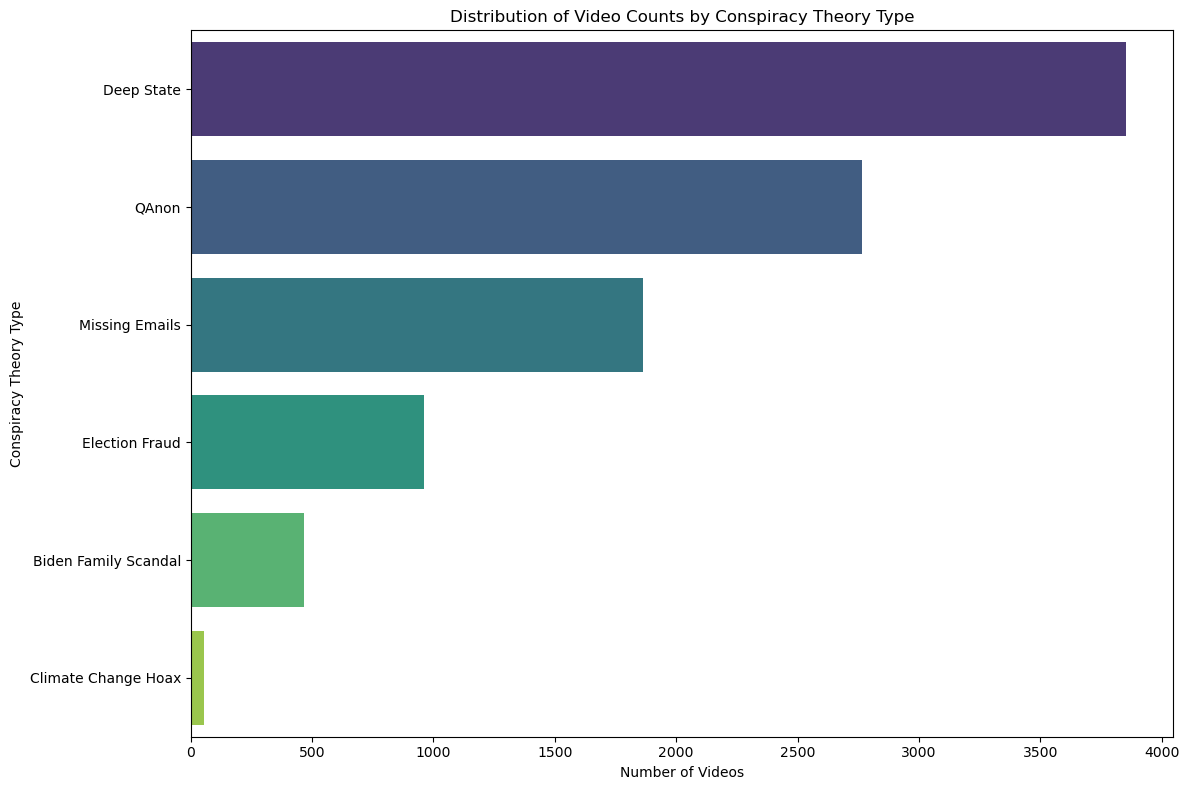

In [ ]:
# Calculate the number of videos for each type of conspiracy theory
type_counts = df_combined_with_conspiracy[list(conspiracy_keywords.keys())].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=type_counts.values, y=type_counts.index, palette='viridis')
plt.title('Distribution of Video Counts by Conspiracy Theory Type')
plt.xlabel('Number of Videos')
plt.ylabel('Conspiracy Theory Type')
plt.tight_layout()
plt.show()


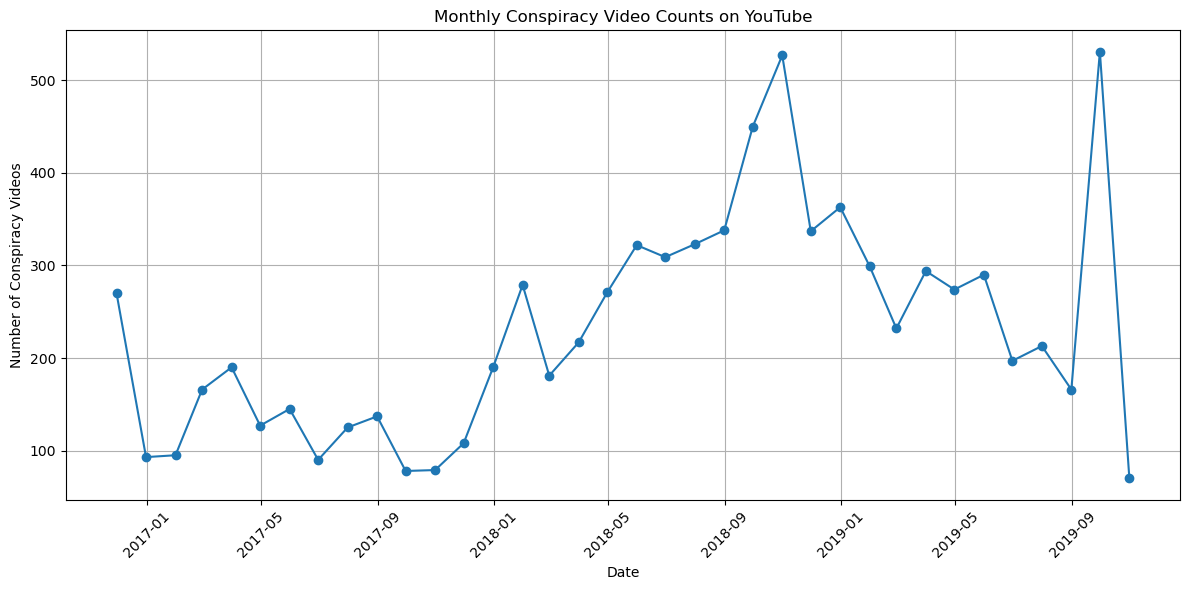

In [ ]:
data = pd.read_csv('conspiracy_videos.csv')

data['upload_date'] = pd.to_datetime(data['upload_date'])
conspiracy_data = data[(data['is_conspiracy'] == 1) & (data['upload_date'] >= '2016-11-01')]

monthly_counts = conspiracy_data.resample('M', on='upload_date').size()

plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.title('Monthly Conspiracy Video Counts on YouTube')
plt.xlabel('Date')
plt.ylabel('Number of Conspiracy Videos')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### A time-series analysis of these videos revealed two primary peaks in content volume: October 2018, coinciding with the U.S. midterm elections, and November 2019, aligning with the start of impeachment discussions. Given the significance of these periods, we focused our analysis on them.

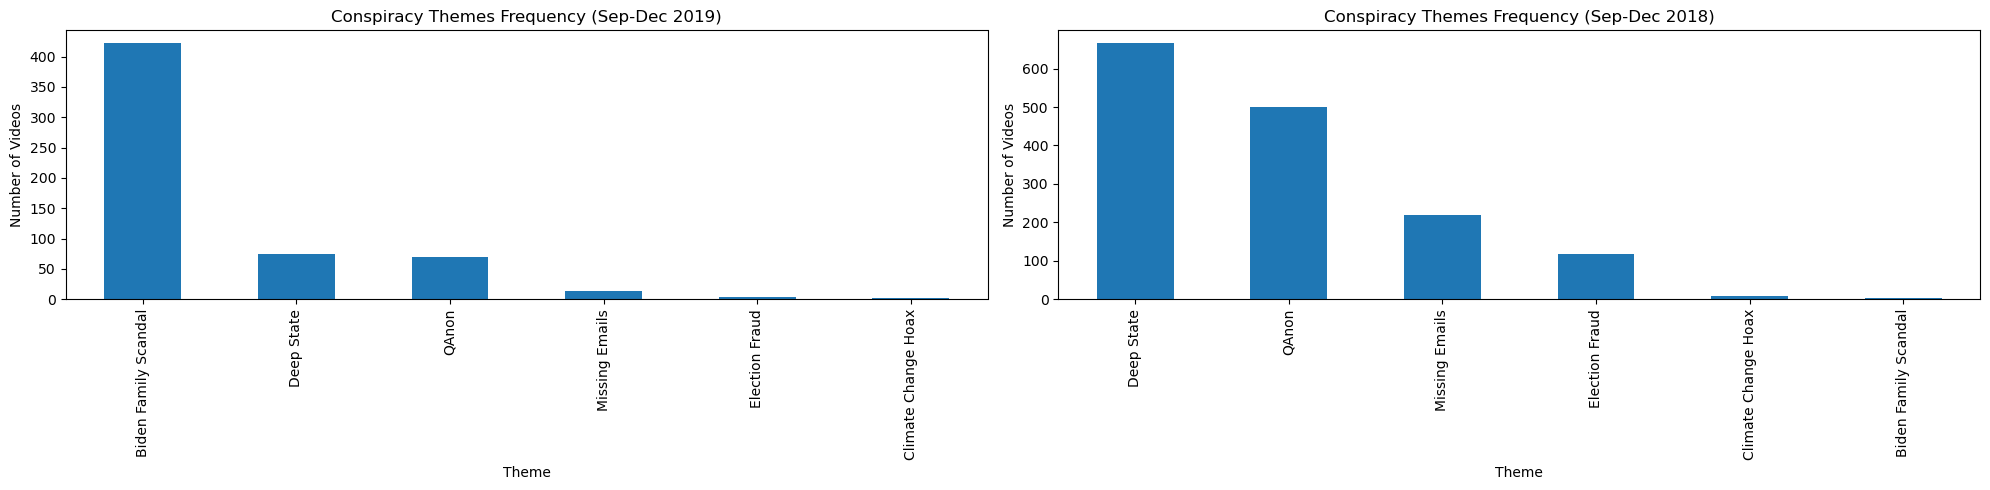

In [36]:
data = pd.read_csv('conspiracy_videos.csv')
data['upload_date'] = pd.to_datetime(data['upload_date'])

# Define the study periods
study_periods = {
    'Sep-Dec 2019': ('2019-09-10', '2019-12-10'),
    'Sep-Dec 2018': ('2018-09-10', '2018-12-10')
}

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Define themes
themes = ['Deep State', 'Election Fraud', 'QAnon', 'Missing Emails', 'Biden Family Scandal', 'Climate Change Hoax']

# Plot for each period
for ax, (period, (start_date, end_date)) in zip(axes, study_periods.items()):
    study_period_data = data[(data['is_conspiracy'] == 1) &
                             (data['upload_date'] >= start_date) &
                             (data['upload_date'] <= end_date)]
    
    theme_counts = study_period_data[themes].sum().sort_values(ascending=False)
    theme_counts.plot(kind='bar', ax=ax)
    ax.set_title(f'Conspiracy Themes Frequency ({period})')
    ax.set_xlabel('Theme')
    ax.set_ylabel('Number of Videos')

plt.tight_layout()
plt.show()


#### From September to December 2019, mentions of the *Biden Family Scandal* surged in conspiracy content, driven by Trump’s focus on alleged Biden corruption amid the impeachment inquiry. Trump emphasized Hunter Biden’s Ukraine dealings to cast doubt on his political opponent and counter the impeachment narrative, fueling widespread conspiracy theories across media platforms.

#### From September to December 2018, "Deep State" and "QAnon" mentions spiked as Trump frequently referenced these conspiracies during the midterm election campaign. By highlighting the "Deep State," he sought to energize his base and frame opposition as part of a hidden government conspiracy, driving public interest and a surge of related content online.

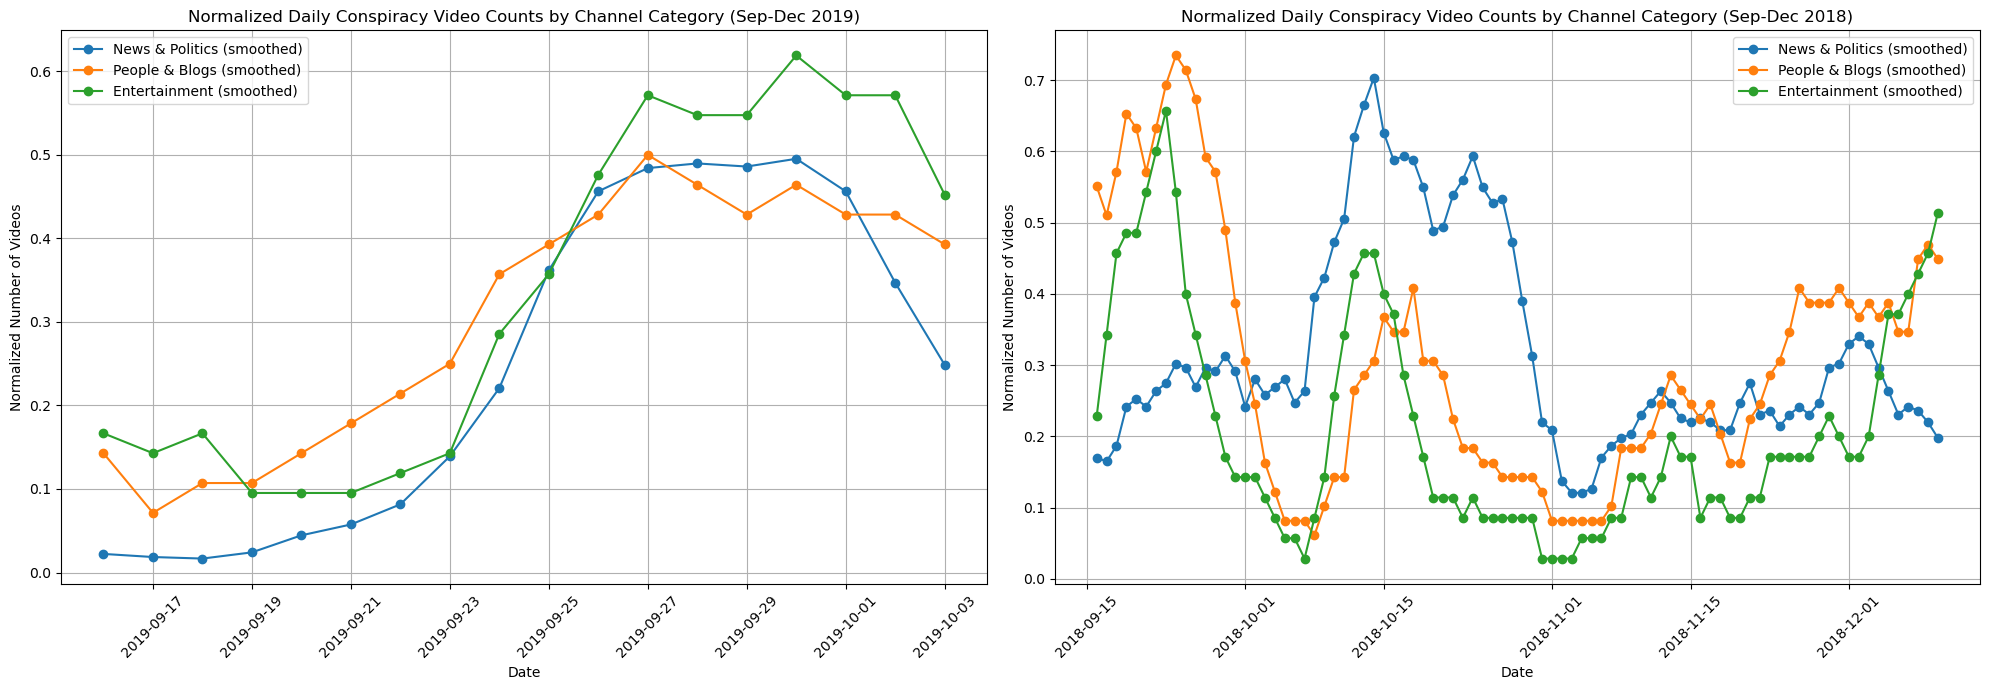

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load data and convert the date column to datetime format
data = pd.read_csv('conspiracy_videos.csv')
data['upload_date'] = pd.to_datetime(data['upload_date'])

# Define study periods
study_periods = {
    'Sep-Dec 2019': ('2019-09-10', '2019-12-10'),
    'Sep-Dec 2018': ('2018-09-10', '2018-12-10')
}

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Channel categories
categories = ['News & Politics', 'People & Blogs', 'Entertainment']

# Iterate over each study period
for ax, (period, (start_date, end_date)) in zip(axes, study_periods.items()):
    # Filter data
    filtered_data = data[(data['is_conspiracy'] == 1) &
                         (data['upload_date'] >= start_date) &
                         (data['upload_date'] <= end_date) &
                         (data['category_cc'].isin(categories))]

    # Count data by date and category
    daily_counts = filtered_data.groupby(['upload_date', 'category_cc']).size().unstack(fill_value=0)
    
    # Normalize data
    scaler = MinMaxScaler()
    normalized_counts = pd.DataFrame(scaler.fit_transform(daily_counts), 
                                     index=daily_counts.index, 
                                     columns=daily_counts.columns)
    
    # Smooth data
    window = 7
    smoothed_counts = normalized_counts.rolling(window=window).mean()

    # Plot each category's curve
    for category in categories:
        ax.plot(smoothed_counts.index, smoothed_counts[category], marker='o', label=f'{category} (smoothed)')
    
    # Set title and labels
    ax.set_title(f'Normalized Daily Conspiracy Video Counts by Channel Category ({period})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Normalized Number of Videos')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


#### To analyze the features we want from the rather messy time series plots, we need to further perform correlation calculations, which means using the principle of convolution to find the temporal order.




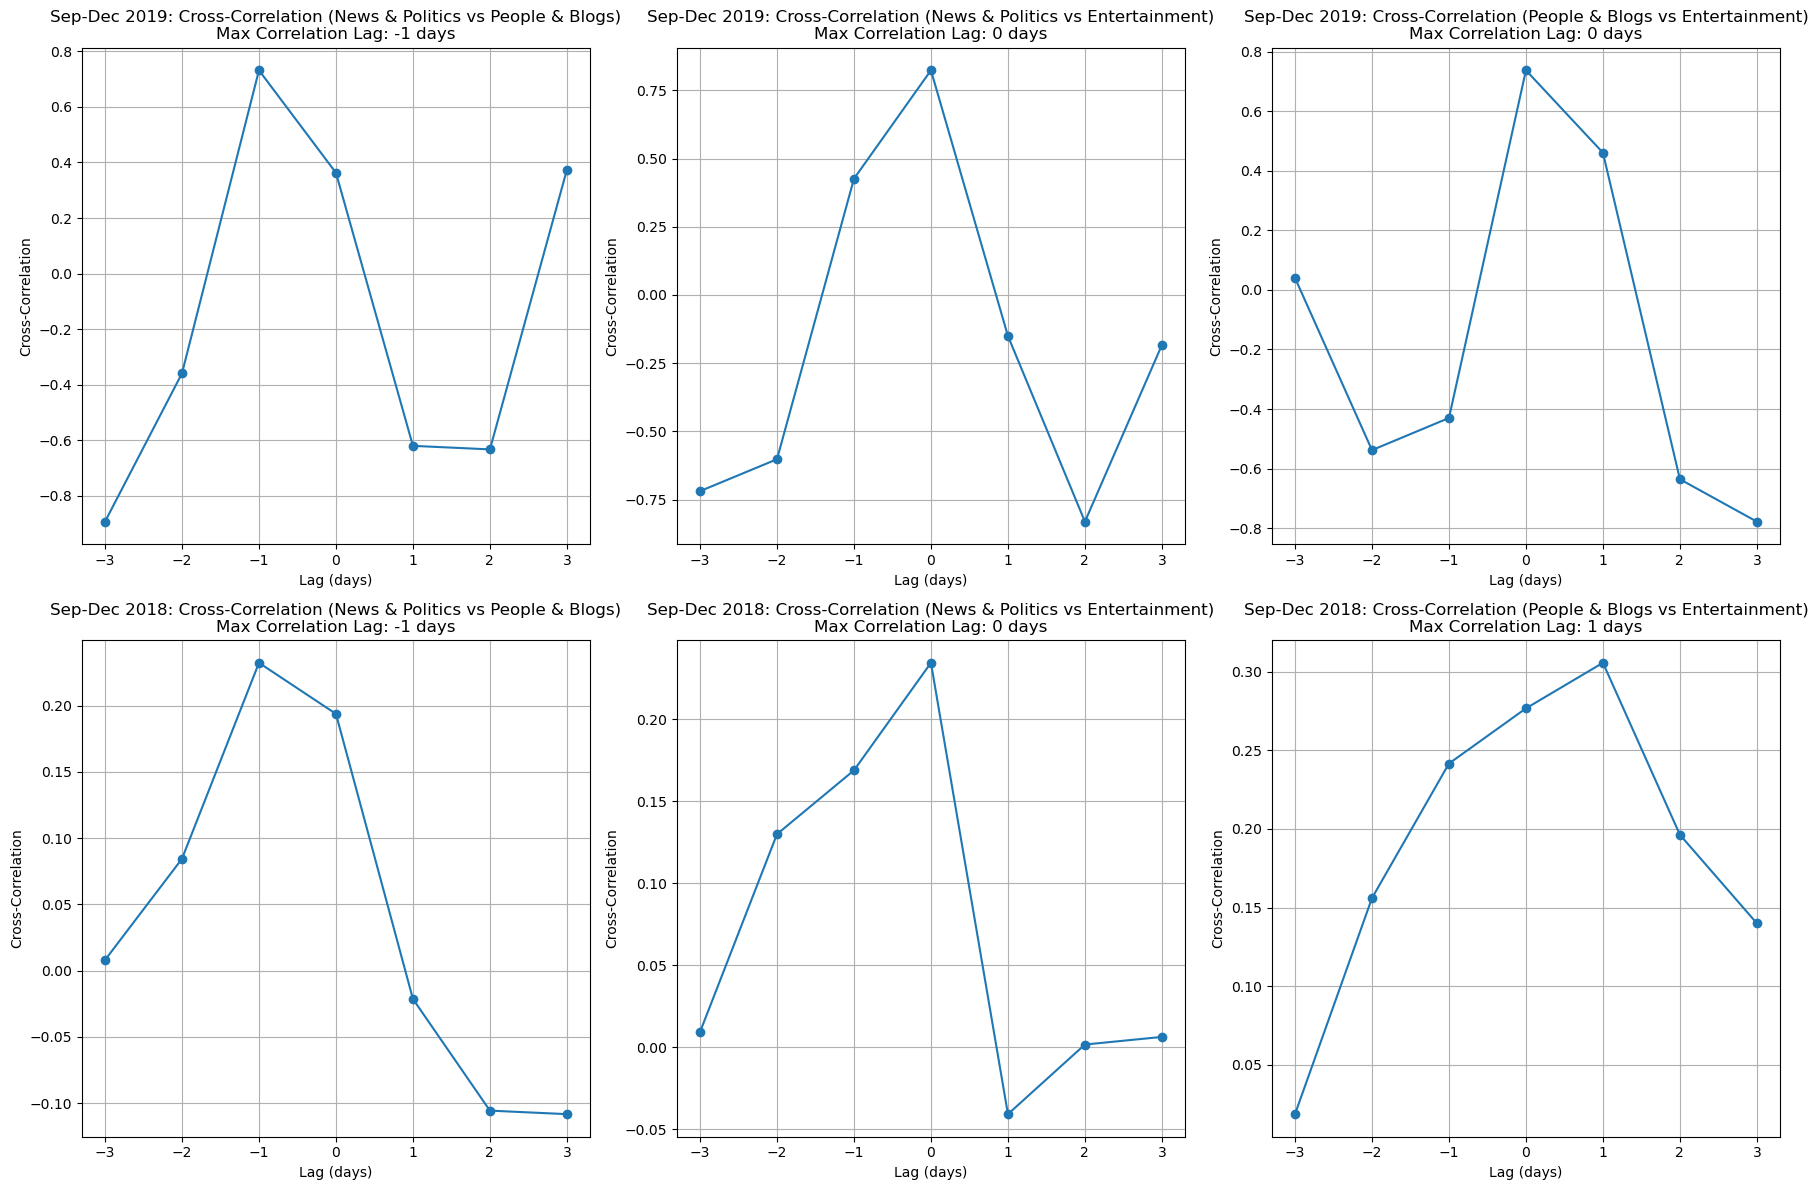

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and prepare data
data = pd.read_csv('conspiracy_videos.csv')
data['upload_date'] = pd.to_datetime(data['upload_date'])

# Define study periods
study_periods = {
    'Sep-Dec 2019': ('2019-09-26', '2019-12-25'),
    'Sep-Dec 2018': ('2018-09-26', '2018-12-25')
}

# Cross-correlation function
def cross_correlation(series1, series2, max_lag=3):
    # Create an array of lag values from -max_lag to max_lag
    lags = np.arange(-max_lag, max_lag + 1)
    
    # Calculate the correlation for each lag value
    correlations = [series1.corr(series2.shift(lag)) for lag in lags]
    
    # Return the lag values and their corresponding correlations
    return lags, correlations

# Plot setup
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (period, (start_date, end_date)) in enumerate(study_periods.items()):
    period_data = data[(data['is_conspiracy'] == 1) &
                       (data['upload_date'] >= start_date) &
                       (data['upload_date'] <= end_date) &
                       ((data['category_cc'] == 'News & Politics') |
                        (data['category_cc'] == 'People & Blogs') |
                        (data['category_cc'] == 'Entertainment'))]
    daily_counts = period_data.groupby(['upload_date', 'category_cc']).size().unstack(fill_value=0)
    scaler = MinMaxScaler()
    normalized_counts = pd.DataFrame(scaler.fit_transform(daily_counts),
                                     index=daily_counts.index,
                                     columns=daily_counts.columns)

    # Calculate cross-correlations and find max lags
    lags, correlations_np_pb = cross_correlation(normalized_counts['News & Politics'], normalized_counts['People & Blogs'])
    max_lag_np_pb = lags[np.argmax(correlations_np_pb)]

    lags, correlations_np_ent = cross_correlation(normalized_counts['News & Politics'], normalized_counts['Entertainment'])
    max_lag_np_ent = lags[np.argmax(correlations_np_ent)]

    lags, correlations_pb_ent = cross_correlation(normalized_counts['People & Blogs'], normalized_counts['Entertainment'])
    max_lag_pb_ent = lags[np.argmax(correlations_pb_ent)]

    # Plot cross-correlations for each category pair with max lag displayed
    axes[idx, 0].plot(lags, correlations_np_pb, marker='o')
    axes[idx, 0].set_title(f'{period}: Cross-Correlation (News & Politics vs People & Blogs)\nMax Correlation Lag: {max_lag_np_pb} days')
    axes[idx, 0].set_xlabel('Lag (days)')
    axes[idx, 0].set_ylabel('Cross-Correlation')
    axes[idx, 0].grid(True)

    axes[idx, 1].plot(lags, correlations_np_ent, marker='o')
    axes[idx, 1].set_title(f'{period}: Cross-Correlation (News & Politics vs Entertainment)\nMax Correlation Lag: {max_lag_np_ent} days')
    axes[idx, 1].set_xlabel('Lag (days)')
    axes[idx, 1].set_ylabel('Cross-Correlation')
    axes[idx, 1].grid(True)

    axes[idx, 2].plot(lags, correlations_pb_ent, marker='o')
    axes[idx, 2].set_title(f'{period}: Cross-Correlation (People & Blogs vs Entertainment)\nMax Correlation Lag: {max_lag_pb_ent} days')
    axes[idx, 2].set_xlabel('Lag (days)')
    axes[idx, 2].set_ylabel('Cross-Correlation')
    axes[idx, 2].grid(True)

plt.tight_layout()
plt.show()


#### The images show cross-correlation of normalized video counts, where a negative lag at peak correlation indicates that the second channel type released content earlier. This highlights the sequential release pattern across channel categories.

#### The results indicate that Trump-related conspiracy content first appears in the People & Blogs category, followed by News & Politics and Entertainment. This sequence is understandable, as People & Blogs videos generally require minimal editing or production, reflecting the public's immediate response. For example, someone might record a segment of a Trump interview on their phone and post it online instantly. News & Politics content follows closely behind, as news segments typically involve more preparation and editing, leading to a slightly delayed release. Entertainment videos are posted later as entertainment creators tend to process information from blogs or news and take additional time to consider how best to adapt the content for maximum engagement, often through added commentary or creative reinterpretation.

# TASK4

In [ ]:
df_timeseries = pd.read_csv('df_timeseries_en.tsv', sep='\t', parse_dates=['datetime'])
df_videos = pd.read_json('yt_metadata_filtered_"trump ".jsonl', lines=True)

df_trump_entertainment_videos = df_videos[df_videos['categories'] == 'Entertainment']
df_trump_non_entertainment_videos = df_videos[df_videos['categories'] != 'Entertainment']

print(f'the shape of entertainment videos are : {df_trump_entertainment_videos.shape}')
print(f'the shape of non-entertainment videos are : {df_trump_non_entertainment_videos.shape}')

the shape of entertainment videos are : (44392, 13)
the shape of non-entertainment videos are : (403224, 13)


## Analyze Like Ratio
#### like_count = (like_count - 0.5*dislike_count) / view_count

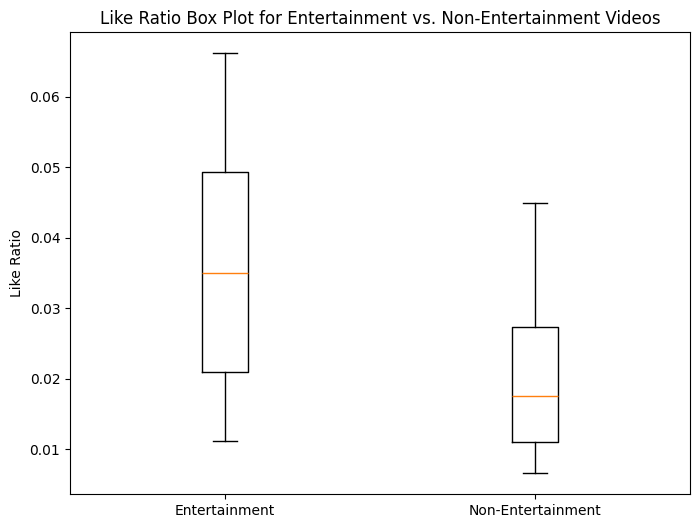

In [ ]:
# Compare the like ratios of entertainment and non-entertainment videos using the formula (like_count - 0.5*dislike_count)/view_count
# Filter out videos with view_count equal to 0
df_trump_entertainment_videos = df_trump_entertainment_videos[df_trump_entertainment_videos['view_count'] > 0]
df_trump_non_entertainment_videos = df_trump_non_entertainment_videos[df_trump_non_entertainment_videos['view_count'] > 0]

pd.options.mode.chained_assignment = None
df_trump_entertainment_videos['like_ratio'] = (df_trump_entertainment_videos['like_count'] - 0.5*df_trump_entertainment_videos['dislike_count']) / df_trump_entertainment_videos['view_count']
df_trump_non_entertainment_videos['like_ratio'] = (df_trump_non_entertainment_videos['like_count'] - 0.5*df_trump_non_entertainment_videos['dislike_count']) / df_trump_non_entertainment_videos['view_count']

# Sort
df_trump_entertainment_videos = df_trump_entertainment_videos.sort_values(by='like_ratio', ascending=False)
df_trump_non_entertainment_videos = df_trump_non_entertainment_videos.sort_values(by='like_ratio', ascending=False)

# Plot boxplot, to reduce error, only plot data between 25%-75%

df_trump_entertainment_videos_new = df_trump_entertainment_videos[df_trump_entertainment_videos['like_ratio'] > df_trump_entertainment_videos['like_ratio'].quantile(0.25)]
df_trump_entertainment_videos_new = df_trump_entertainment_videos_new[df_trump_entertainment_videos_new['like_ratio'] < df_trump_entertainment_videos_new['like_ratio'].quantile(0.75)]

df_trump_non_entertainment_videos_new = df_trump_non_entertainment_videos[df_trump_non_entertainment_videos['like_ratio'] > df_trump_non_entertainment_videos['like_ratio'].quantile(0.25)]
df_trump_non_entertainment_videos_new = df_trump_non_entertainment_videos_new[df_trump_non_entertainment_videos_new['like_ratio'] < df_trump_non_entertainment_videos_new['like_ratio'].quantile(0.75)]

plt.figure(figsize=(8, 6))
plt.boxplot([df_trump_entertainment_videos_new['like_ratio'], df_trump_non_entertainment_videos_new['like_ratio']], tick_labels=['Entertainment', 'Non-Entertainment'])
plt.title('Like Ratio Box Plot for Entertainment vs. Non-Entertainment Videos')
plt.ylabel('Like Ratio')
plt.show()

#### Entertainment videos generally achieve higher Like Ratios, potentially making them more appealing or engaging for viewers. This suggests that the entertainment format might be a key factor in enhancing viewer engagement, possibly due to a preference for lighter, more entertaining content on this topic. 

#### One channel made more than 10,000 videos about Trump. This is a representative case, so let's sort them by upload time and analyze the changes in view_count.

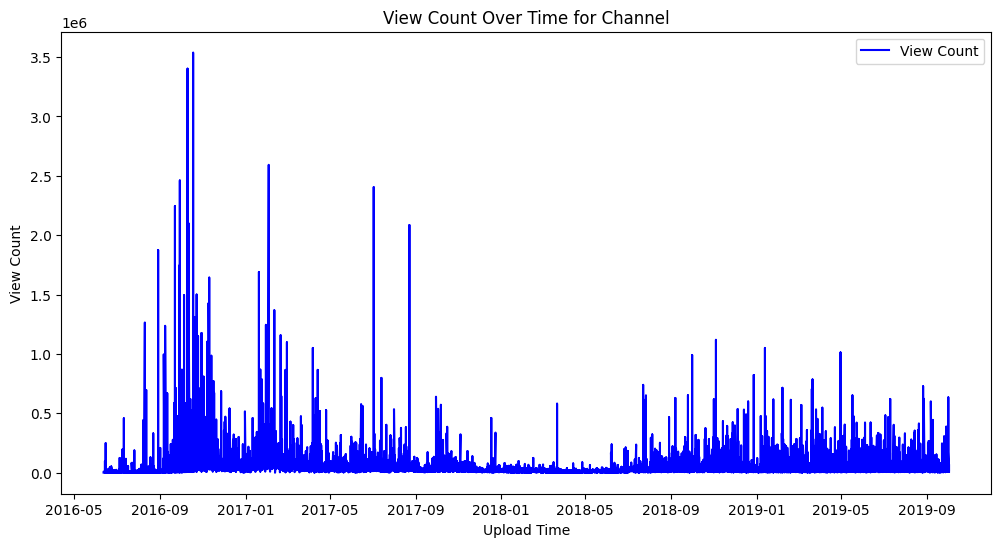

In [ ]:
# Count the number of videos per channel
df_trump_entertainment_videos_channel = df_trump_entertainment_videos.groupby('channel_id').size()

# Display the results
df_trump_entertainment_videos_channel.sort_values(ascending=False)

# Assume df_trump_entertainment_videos_channel is your DataFrame
highest_channel = df_trump_entertainment_videos.iloc[0]['channel_id']
df = df_trump_entertainment_videos[df_trump_entertainment_videos['channel_id'] == highest_channel]

# Step 1: Convert the 'upload_time' column to datetime type and sort by time
df['upload_date'] = pd.to_datetime(df['upload_date'])
df = df.sort_values('upload_date')

# Step 2: Set 'upload_time' as the index
df.set_index('upload_date', inplace=True)

# Step 3: Plot the change in view count over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['view_count'], color='b', label='View Count')
plt.xlabel('Upload Time')
plt.ylabel('View Count')
plt.title('View Count Over Time for Channel')
plt.legend()
plt.show()


#### Conclusions:

The time series plot above shows the view count over time for videos related to Trump from a specific channel. Here’s an analysis of the view count trends in connection to notable events:

1. **Initial Spike in Mid-2016**: 
   - In mid-2016, there’s a sharp increase in view counts, likely connected to Trump’s campaign activities as he was the Republican candidate for the U.S. presidential election. Public interest surged as media coverage intensified around his campaign speeches, debates, and controversies.

2. **Peak in Late 2016**:
   - The view count peaks around late 2016, coinciding with the U.S. presidential election in November 2016. This period includes Trump’s victory and the global reaction, which may have driven high engagement with related content. As people sought more information and opinions about the new president-elect, channels covering Trump-related content likely saw increased viewership.

3. **Steady Decline Through 2017**:
   - Post-election, there’s a gradual decline in view counts through 2017, though with occasional spikes. This period corresponds with Trump’s early days in office. Major policy announcements, the controversy surrounding his decisions, or significant events (such as executive orders and international relations issues) might have triggered temporary spikes in viewership.

4. **Renewed Interest in Mid-2018**:
   - Another noticeable increase occurs around mid-2018, which could be related to significant events in Trump’s presidency, such as the North Korea–United States summit in June 2018 or developments in the Mueller investigation. These high-profile events likely renewed public interest, leading to increased view counts.

5. **Consistent Engagement Through 2019**:
   - Although the peaks are lower, there is a relatively steady viewership through 2019. This sustained engagement could reflect ongoing interest in Trump-related topics, potentially driven by events like impeachment proceedings or the anticipation of the 2020 election. Content discussing Trump’s policies, actions, and public statements may have kept the audience’s attention.

**Conclusion**:
This view count trend demonstrates how political events and global interest in Trump’s activities have impacted video viewership on this channel. Peaks correspond to major milestones or controversies, suggesting that current events strongly influence audience engagement with politically themed entertainment content. This analysis highlights the importance of timing in content creation, especially when covering high-profile figures in rapidly changing political landscapes.

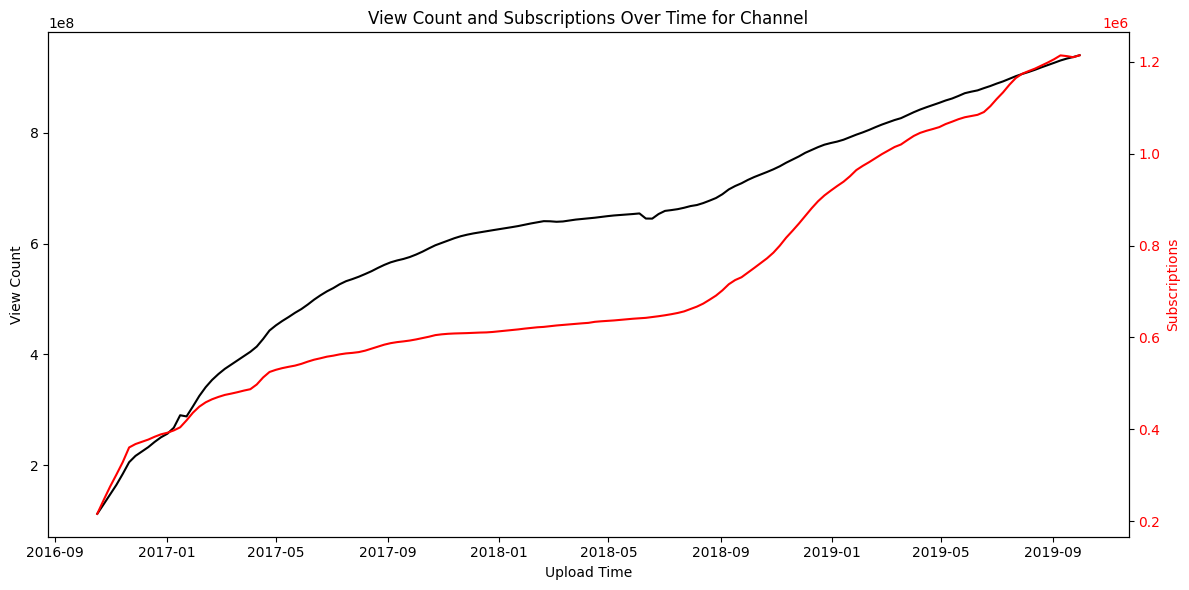

In [ ]:
# Assume your data is ready
df2 = df_timeseries[df_timeseries['channel'] == highest_channel]

# Step 1: Convert the 'datetime' column to datetime type and sort by time
df2['datetime'] = pd.to_datetime(df2['datetime'])
df2 = df2.sort_values('datetime')

# Step 2: Set 'datetime' as the index
df2.set_index('datetime', inplace=True)

# Step 3: Plot the changes in view count and subscriptions
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y-axis: View Count
ax1.plot(df2.index, df2['views'], color='black', label='View Count')
ax1.set_xlabel('Upload Time')
ax1.set_ylabel('View Count', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Right Y-axis: Subscriptions
ax2 = ax1.twinx()
ax2.plot(df2.index, df2['subs'], color='r', label='Subscriptions')
ax2.set_ylabel('Subscriptions', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
plt.title('View Count and Subscriptions Over Time for Channel')
fig.tight_layout()  # Automatically adjust layout
plt.show()

#### The chart shows the cumulative growth of view counts (in black) and subscriptions (in red) over time for a channel focused on Trump-related content from 2016 to 2019. We observe a steady increase in both metrics, with a more pronounced growth during key political events, such as Trump's 2016 election victory and other major policy decisions. The view count has consistently remained higher than subscriptions, reflecting the broader reach of the videos. Notably, both metrics experience sharp increases periodically, likely correlating with major news events surrounding Trump, driving viewer interest and engagement.

# TASK5

In [ ]:
filename = f"yt_metadata_filtered_trump.jsonl.gz"
df = pd.read_json(filename, lines=True, compression='gzip') # Read the dataset
df = df.dropna(subset=['like_count', 'dislike_count', 'view_count', 'duration'])
df = df[df['view_count'] >= 5000] # Filter out videos with view counts greater than or equal to 5000
# For each entry in the categories feature of the DataFrame df, 
# ‘entertainment’ will be set to 1 if it is 'Entertainment', otherwise it will be set to 0.
df['entertainment'] = df['categories'].apply(lambda x: 1 if 'Entertainment' in x else 0)
with open('conspiracy_words.json', 'r') as f:
    conspiracy_data = json.load(f) # Read the JSON file

conspiracy_names = [theory['name'] for theory in conspiracy_data['conspiracy_theories']] # get all the 'name's in the json file

# Create a boolean index to check if the title or tags contain any of the conspiracy_names.
conspiracy_check = df['title'].str.contains('|'.join(conspiracy_names), case=False, na=False) | \
                   df['tags'].str.contains('|'.join(conspiracy_names), case=False, na=False)

# Assign the boolean values directly to the 'conspiracy' column as integers (1 for True, 0 for False)
df.loc[:, 'conspiracy'] = conspiracy_check.astype(int)

In [ ]:
cons_and_enter = df[(df['entertainment'] == 1) & (df['conspiracy'] == 1)]
only_enter = df[(df['entertainment'] == 1) & (df['conspiracy'] == 0)]
only_cons = df[(df['entertainment'] == 0) & (df['conspiracy'] == 1)]
control = df[(df['entertainment'] == 0) & (df['conspiracy'] == 0)]


## 1. Descriptive Statistics

In [ ]:
cons_and_enter.like_count.describe()

count      519.000000
mean      2581.579961
std       2647.678449
min         15.000000
25%        824.500000
50%       1692.000000
75%       3861.000000
max      23551.000000
Name: like_count, dtype: float64

In [ ]:
only_enter.like_count.describe()

count    2.815200e+04
mean     3.984024e+03
std      1.689000e+04
min      0.000000e+00
25%      4.770000e+02
50%      1.112000e+03
75%      2.498000e+03
max      1.235449e+06
Name: like_count, dtype: float64

In [ ]:
only_cons.like_count.describe()

count     2938.000000
mean      2642.297822
std       4483.900351
min          6.000000
25%        542.000000
50%       1084.000000
75%       2663.500000
max      57057.000000
Name: like_count, dtype: float64

In [ ]:
control.like_count.describe()

count    1.765400e+05
mean     2.106702e+03
std      1.472457e+04
min      0.000000e+00
25%      1.650000e+02
50%      4.820000e+02
75%      1.436000e+03
max      2.864436e+06
Name: like_count, dtype: float64

We found that both the median is arranged in the following order from largest to smallest: videos that contain conspiracy theory keywords and are also in the entertainment category > videos that are purely entertainment > videos that only contain conspiracy theory keywords > control group videos.


## 2. Investigating the difference in likes between entertainment and non-entertainment videos

In [ ]:
entertainment = df[df['entertainment'] == 1]
control_entertainment = df[df['entertainment'] == 0]

In [ ]:
entertainment.like_count.describe()

count    2.867100e+04
mean     3.958637e+03
std      1.674125e+04
min      0.000000e+00
25%      4.840000e+02
50%      1.120000e+03
75%      2.525000e+03
max      1.235449e+06
Name: like_count, dtype: float64

In [ ]:
control_entertainment.like_count.describe()

count    1.794780e+05
mean     2.115470e+03
std      1.461498e+04
min      0.000000e+00
25%      1.670000e+02
50%      4.910000e+02
75%      1.457000e+03
max      2.864436e+06
Name: like_count, dtype: float64

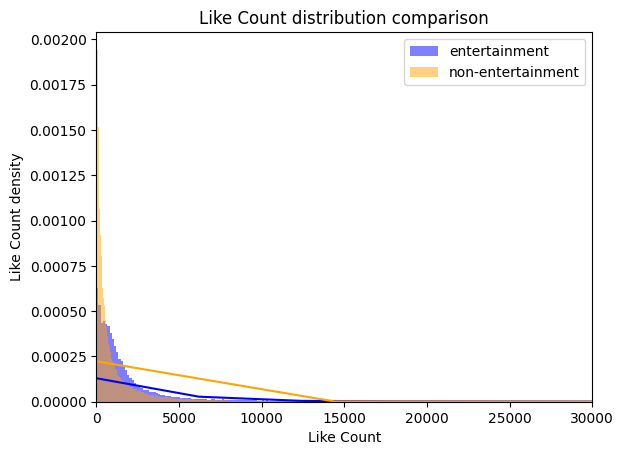

In [ ]:
ax = sns.histplot(entertainment['like_count'], kde=True, stat='density', color='blue', label='entertainment')
ax = sns.histplot(control_entertainment['like_count'], kde=True, stat='density', color='orange', label='non-entertainment')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

It can be observed that in the range of 2,000 to 10,000 likes, the proportion of entertainment videos is higher.

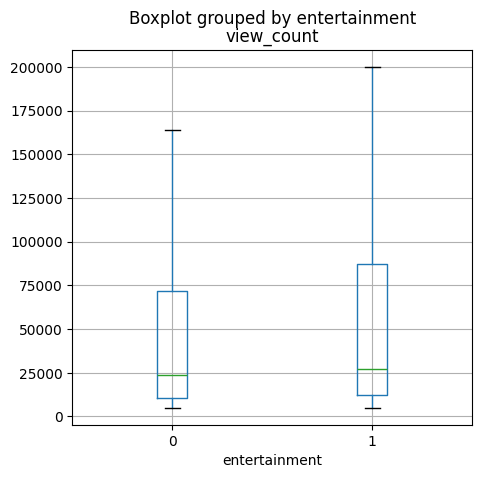

In [ ]:
df.boxplot(by='entertainment', column='view_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

 Intuitively, view count may be an important factor affecting the number of likes. From this boxplot, we can see that although the means of the two groups are close, it seems that the entertainment group has a higher upper quatile for view count.


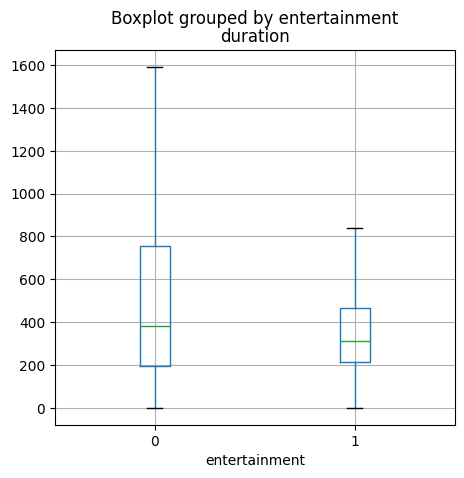

In [ ]:
df.boxplot(by='entertainment', column='duration', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

An interesting finding is that the videos in the non-entertainment group are often longer than those in the entertainment group.

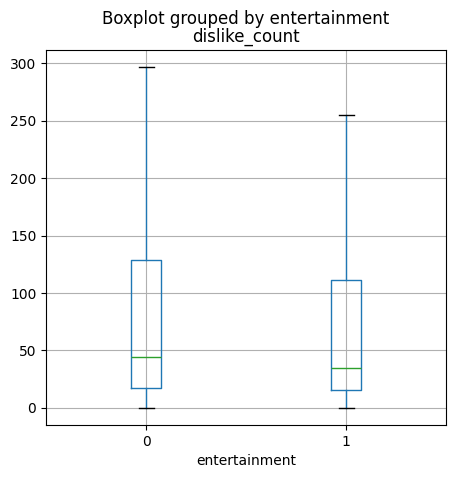

In [ ]:
df.boxplot(by='entertainment', column='dislike_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

#### The non-entertainment group often has more dislikes than the entertainment group.

#### Many factors can influence the like count, and it is challenging to find two nearly identical videos for comparison. Therefore, we use propensity scores to balance the impact of other factors.

In [ ]:
# Standardize the features
df['dislike_count'] = (df['dislike_count'] - df['dislike_count'].mean())/df['dislike_count'].std()
df['duration'] = (df['duration'] - df['duration'].mean())/df['duration'].std()
df['view_count'] = (df['view_count'] - df['view_count'].mean())/df['view_count'].std()

mod = smf.logit(formula='entertainment ~ dislike_count + duration + view_count + C(conspiracy)', data=df)

res = mod.fit()

# Extract the estimated propensity scores
df['Propensity_score_entertainment'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.397908
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          entertainment   No. Observations:               208149
Model:                          Logit   Df Residuals:                   208144
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                0.007327
Time:                        20:17:03   Log-Likelihood:                -82824.
converged:                       True   LL-Null:                       -83435.
Covariance Type:            nonrobust   LLR p-value:                1.946e-263
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.8687      0.007   -277.803      0.000      -1.882      -1.856
C(con

In [ ]:
entertainment = df.loc[df['entertainment'] == 1] # Videos that contain conspiracy keywords in the title or tags
control_entertainment = df.loc[df['entertainment'] == 0] # Videos that do not contain conspiracy keywords in the title or tags
# Randomly sample to reduce running time
entertainment_sample = entertainment.sample(frac=0.01, random_state=42) 
control_entertainment_sample = control_entertainment.sample(frac=0.0034, random_state=42)


In [ ]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [ ]:
# Create an empty undirected graph
G = nx.Graph()
i = 0
# Loop through all the pairs of instances
for control_id, control_row in control_entertainment_sample.iterrows():
    for treatment_id, treatment_row in entertainment_sample.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score_entertainment'],
                                    treatment_row['Propensity_score_entertainment'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

        

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [ ]:
# Create a list of matched indices
matched = []
for pair in matching:
    matched.append(pair[0])  # Control group index
    matched.append(pair[1])  # Treatment group index

# Create balanced DataFrame using original indices
balanced_df_entertainment = df.loc[df.index.isin(matched)]

In [ ]:
entertainment = balanced_df_entertainment.loc[balanced_df_entertainment['entertainment'] == 1]
non_entertainment = balanced_df_entertainment.loc[balanced_df_entertainment['entertainment'] == 0]

In [ ]:
entertainment.like_count.describe()

count       287.000000
mean       4710.637631
std       21094.810975
min           5.000000
25%         484.500000
50%        1114.000000
75%        2829.000000
max      341505.000000
Name: like_count, dtype: float64

In [ ]:
non_entertainment.like_count.describe()

count       287.000000
mean       2481.459930
std        8752.690213
min           2.000000
25%         164.500000
50%         492.000000
75%        1580.000000
max      122457.000000
Name: like_count, dtype: float64

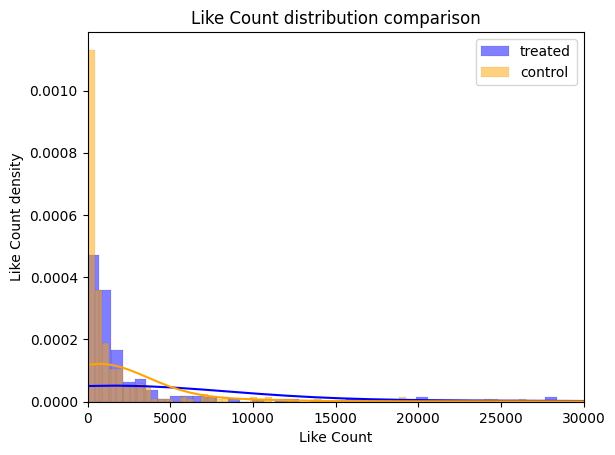

In [ ]:
ax = sns.histplot(entertainment['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(non_entertainment['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

 #### We can observe that in the like range above 5,000, the proportion of entertainment videos is higher.

In [ ]:
stats.ttest_ind(entertainment['like_count'], non_entertainment['like_count'], alternative='greater') # t-Test

TtestResult(statistic=1.6535471463835063, pvalue=0.04938411178622452, df=572.0)

#### Since the p-value is less than 0.05, we can reject the null hypothesis that the like count of entertainment videos is less than or equal to that of non-entertainment videos. This means that the like count of entertainment videos is significantly greater than that of non-entertainment videos.

## 3. Investigating the impact of whether a video's title or tags contain conspiracy theory keywords on the like count

In [ ]:
filename = f"yt_metadata_filtered_trump.jsonl.gz"
df = pd.read_json(filename, lines=True, compression='gzip') # Read the dataset
df = df.dropna(subset=['like_count', 'dislike_count', 'view_count', 'duration'])
df = df[df['view_count'] >= 5000] # Filter out videos with view counts greater than or equal to 5000
# For each entry in the categories feature of the DataFrame df, 
# ‘entertainment’ will be set to 1 if it is 'Entertainment', otherwise it will be set to 0.
df['entertainment'] = df['categories'].apply(lambda x: 1 if 'Entertainment' in x else 0)
with open('conspiracy_words.json', 'r') as f:
    conspiracy_data = json.load(f) # Read the JSON file

conspiracy_names = [theory['name'] for theory in conspiracy_data['conspiracy_theories']] # get all the 'name's in the json file

# Create a boolean index to check if the title or tags contain any of the conspiracy_names.
conspiracy_check = df['title'].str.contains('|'.join(conspiracy_names), case=False, na=False) | \
                   df['tags'].str.contains('|'.join(conspiracy_names), case=False, na=False)

# Assign the boolean values directly to the 'conspiracy' column as integers (1 for True, 0 for False)
df.loc[:, 'conspiracy'] = conspiracy_check.astype(int)

In [ ]:
conspiracy = df[df['conspiracy'] == 1]
non_conspiracy = df[df['conspiracy'] == 0]

In [ ]:
conspiracy.like_count.describe()

count     3457.000000
mean      2633.182239
std       4258.785839
min          6.000000
25%        574.000000
50%       1160.000000
75%       2827.000000
max      57057.000000
Name: like_count, dtype: float64

In [ ]:
non_conspiracy.like_count.describe()

count    2.046920e+05
mean     2.364897e+03
std      1.505474e+04
min      0.000000e+00
25%      1.820000e+02
50%      5.520000e+02
75%      1.599000e+03
max      2.864436e+06
Name: like_count, dtype: float64

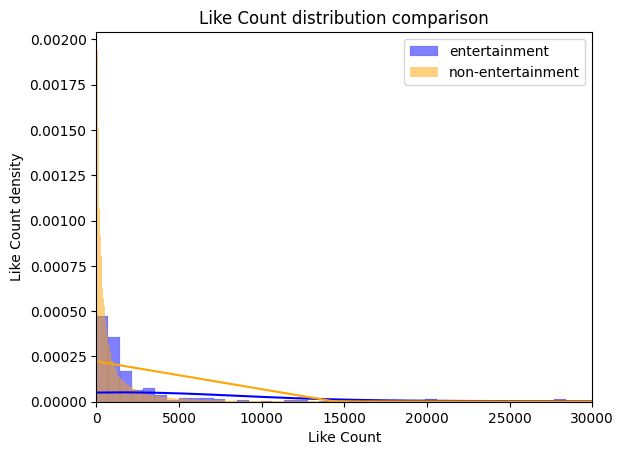

In [ ]:
ax = sns.histplot(entertainment['like_count'], kde=True, stat='density', color='blue', label='entertainment')
ax = sns.histplot(control_entertainment['like_count'], kde=True, stat='density', color='orange', label='non-entertainment')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

#### It can be observed that in the range of > 2000 likes, the proportion of entertainment videos is higher.

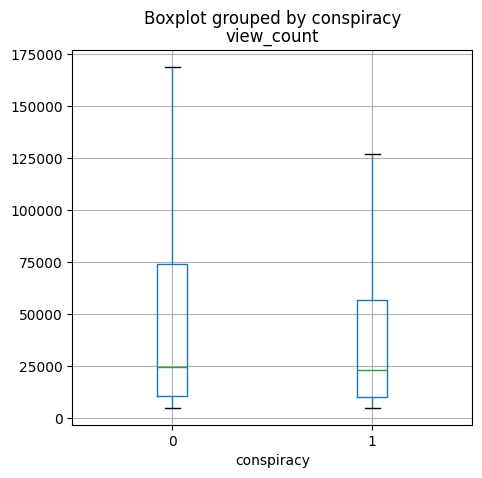

In [ ]:
df.boxplot(by='conspiracy', column='view_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

#### View Count: We can see that although the means of the two groups are close, it seems that the non-conspiracy group has a higher upper quatile for view count.


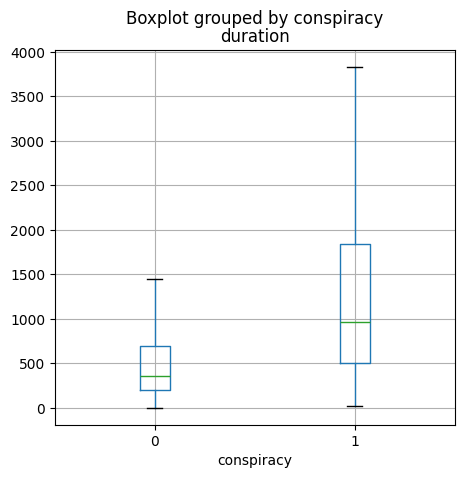

In [ ]:
df.boxplot(by='conspiracy', column='duration', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

#### An interesting finding is that the videos in the conspiracy group are often longer than those in the non-conspiracy group.

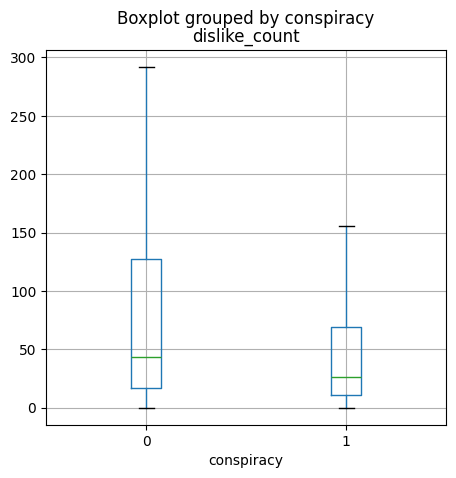

In [ ]:
df.boxplot(by='conspiracy', column='dislike_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()

#### The non-conspiracy group often has more dislikes than the entertainment group.

In [ ]:
# Standardize the features
df['dislike_count'] = (df['dislike_count'] - df['dislike_count'].mean())/df['dislike_count'].std()
df['duration'] = (df['duration'] - df['duration'].mean())/df['duration'].std()
df['view_count'] = (df['view_count'] - df['view_count'].mean())/df['view_count'].std()

mod = smf.logit(formula='conspiracy ~ dislike_count + duration + view_count + C(entertainment)', data=df)

res = mod.fit()

# Extract the estimated propensity scores
df['Propensity_score_conspiracy'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.083908
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             conspiracy   No. Observations:               208149
Model:                          Logit   Df Residuals:                   208144
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Nov 2024   Pseudo R-squ.:                0.007339
Time:                        20:19:24   Log-Likelihood:                -17465.
converged:                       True   LL-Null:                       -17594.
Covariance Type:            nonrobust   LLR p-value:                 1.087e-54
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.1821      0.021   -195.253      0.000      -4.224      -4

In [ ]:
conspiracy = df.loc[df['conspiracy'] == 1] # Videos that contain conspiracy keywords in the title or tags
non_conspiracy = df.loc[df['conspiracy'] == 0] # Videos that do not contain conspiracy keywords in the title or tags
# Randomly sample to reduce running time
conspiracy_sample = conspiracy.sample(frac=0.1, random_state=42) 
non_conspiracy_sample = non_conspiracy.sample(frac=0.002, random_state=42)


In [ ]:
# Create an empty undirected graph
G = nx.Graph()
i = 0
# Loop through all the pairs of instances
for control_id, control_row in non_conspiracy_sample.iterrows():
    for treatment_id, treatment_row in conspiracy_sample.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score_conspiracy'],
                                    treatment_row['Propensity_score_conspiracy'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

        

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [ ]:
# Create a list of matched indices
matched = []
for pair in matching:
    matched.append(pair[0])  # Control group index
    matched.append(pair[1])  # Treatment group index

# Create balanced DataFrame using original indices
balanced_df_conspiracy = df.loc[df.index.isin(matched)]

In [ ]:
conspiracy = balanced_df_conspiracy.loc[balanced_df_conspiracy['conspiracy'] == 1]
non_conspiracy = balanced_df_conspiracy.loc[balanced_df_conspiracy['conspiracy'] == 0]

In [ ]:
conspiracy.like_count.describe()

count      346.000000
mean      2809.841040
std       4017.039265
min         86.000000
25%        603.000000
50%       1397.500000
75%       3171.750000
max      23551.000000
Name: like_count, dtype: float64

In [ ]:
non_conspiracy.like_count.describe()

count       346.000000
mean       1474.343931
std        6262.360551
min           0.000000
25%         143.750000
50%         365.000000
75%        1067.250000
max      105875.000000
Name: like_count, dtype: float64

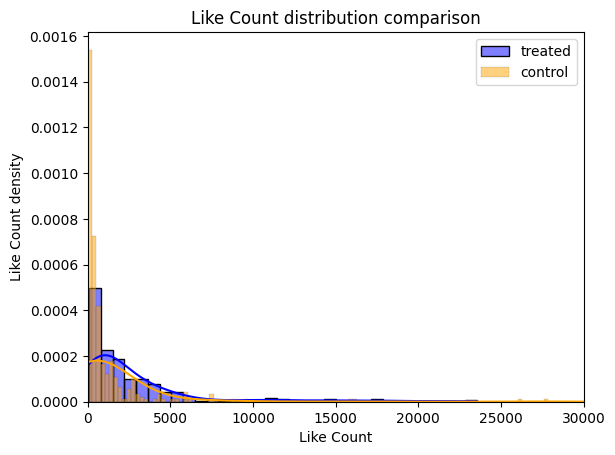

In [ ]:
ax = sns.histplot(conspiracy['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(non_conspiracy['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

#### We can observe that in the like range above 1,000, the proportion of conspiracy videos is higher.

In [ ]:
stats.ttest_ind(conspiracy['like_count'], non_conspiracy['like_count'], alternative='greater') # t-Test

TtestResult(statistic=3.3389308320991096, pvalue=0.0004431124245444349, df=690.0)

#### Since the p-value is less than 0.05, we can reject the null hypothesis that the like count of conspiracy videos is less than or equal to that of non-conspiracy videos. This means that the like count of conspiracy videos is significantly greater than that of non-conspiracy videos.

## 4. Plans

#### Next, we plan to explore the independent effects of these two factors by building a regression model. We will then add an interaction term for the two factors to examine how their interaction affects the like count. Additionally, we will further consider the video's release time as a potential factor that may influence the like count.